# Naive Bayes Modeling

In [62]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import *
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

## Agenda

SWBAT:

- 

## Using Bayes's Theorem for Classification

Let's recall Bayes's Theorem:

$\large P(h|e) = \frac{P(h)P(e|h)}{P(e)}$

**Does this look like a classification problem?**

- Suppose we have three competing hypotheses $\{h_1, h_2, h_3\}$ that would explain our evidence $e$.
    - Then we could use Bayes's Theorem to calculate the posterior probabilities for each of these three:
        - $P(h_1|e) = \frac{P(h_1)P(e|h_1)}{P(e)}$
        - $P(h_2|e) = \frac{P(h_2)P(e|h_2)}{P(e)}$
        - $P(h_3|e) = \frac{P(h_3)P(e|h_3)}{P(e)}$
        
- Suppose the evidence is a collection of elephant heights and weights.

- Suppose each of the three hypotheses claims that the elephant whose measurements we have belongs to one of the three extant elephant species (*L. africana*, *L. cyclotis*, and *E. maximus*).

In that case the left-hand sides of these equations represent the probability that the elephant in question belongs to a given species.

If we think of the species as our target, then **this is just an ordinary classification problem**.

What about the right-hand sides of the equations? **These other probabilities we can calculate from our dataset.**

### Comma Survey Example

In [95]:
commas = pd.read_csv('data/comma-survey.csv')

In [96]:
commas.head()

,RespondentID,"In your opinion, which sentence is more gramatically correct?","Prior to reading about it above, had you heard of the serial (or Oxford) comma?","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?",How would you write the following sentence?,"When faced with using the word ""data"", have you ever spent time considering if the word was a singular or plural noun?","How much, if at all, do you care about the debate over the use of the word ""data"" as a singluar or plural noun?","In your opinion, how important or unimportant is proper use of grammar?",Gender,Age,Household Income,Education,Location (Census Region)
0,3292953864,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Not much,Somewhat important,Male,30-44,"$50,000 - $99,999",Bachelor degree,South Atlantic
1,3292950324,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,Somewhat unimportant,Male,30-44,"$50,000 - $99,999",Graduate degree,Mountain
2,3292942669,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",Yes,Not at all,Very important,Male,30-44,NaN,NaN,East North Central
3,3292932796,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Some,Somewhat important,Male,18-29,NaN,Less than high school degree,Middle Atlantic
4,3292932522,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,NaN,NaN,NaN,NaN,NaN,NaN


The first question on the survey was about the Oxford comma.

In [97]:
commas['In your opinion, which sentence is more gramatically correct?'].value_counts()

It's important for a person to be honest, kind, and loyal.    641
It's important for a person to be honest, kind and loyal.     488
Name: In your opinion, which sentence is more gramatically correct?, dtype: int64

Personally, I like the Oxford comma, since it can help eliminate ambiguities, such as:

"This book is dedicated to my parents, Ayn Rand, and God" <br/> vs. <br/>
"This book is dedicated to my parents, Ayn Rand and God"

Let's see if there's an interesting correlation between Oxford comma preference and age.

In [99]:
commas['Age'].value_counts()

45-60    290
> 60     272
30-44    254
18-29    221
Name: Age, dtype: int64

#### Calculating Priors and Likelihoods

The following code makes a table of values that count up the number of survey respondents who fall into each of eight bins (the four age groups and the two answers to the first comma question). 

In [102]:
table = np.zeros((2, 4))

for idx, value in enumerate(commas['Age'].value_counts().index):
    table[0, idx] = len(commas[(commas['In your opinion, which sentence is '\
                                       'more gramatically correct?'] ==\
                                        'It\'s important for a person to be '\
                                'honest, kind, and loyal.') & (commas['Age'] == value)])
    table[1, idx] = len(commas[(commas['In your opinion, which sentence is '\
                                       'more gramatically correct?'] ==\
                                        'It\'s important for a person to be '\
                                'honest, kind and loyal.') & (commas['Age'] == value)])

In [103]:
table

array([[142., 123., 155., 174.],
       [148., 149.,  99.,  47.]])

In [105]:
df = pd.DataFrame(table, columns=['Age45-60',
                            'Age>60',
                            'Age30-44',
                            'Age18-29'])
df

,Age45-60,Age>60,Age30-44,Age18-29
0,142.0,123.0,155.0,174.0
1,148.0,149.0,99.0,47.0


In [109]:
df['Oxford'] = [True, False]
df = df[['Age>60', 'Age45-60', 'Age30-44', 'Age18-29', 'Oxford']]
df

,Age>60,Age45-60,Age30-44,Age18-29,Oxford
0,123.0,142.0,155.0,174.0,True
1,149.0,148.0,99.0,47.0,False


### Elephant Example

Suppose we have a dataset that looks like this:

In [36]:
elephs = pd.read_csv('data/elephants.csv', usecols=['height (in)',
                                                   'weight (lbs)',
                                                   'species'])

In [37]:
elephs.head()

,height (in),weight (lbs),species
0,231.683867,6469.491895,maximus
1,277.714843,7639.806953,cyclotis
2,268.228131,8561.517693,africana
3,267.334322,7673.608014,cyclotis
4,270.165582,7259.901759,maximus


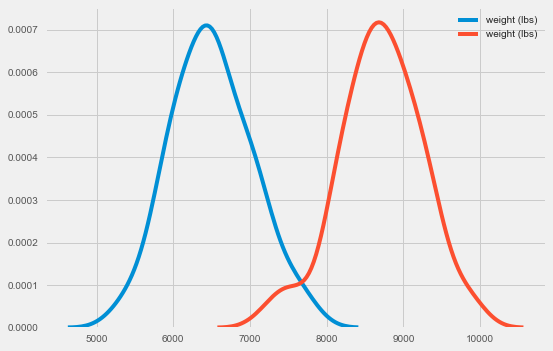

In [87]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

sns.kdeplot(data=elephs[elephs['species'] == 'maximus']['weight (lbs)'], ax=ax)
sns.kdeplot(data=elephs[elephs['species'] == 'africana']['weight (lbs)'], ax=ax);

In [88]:
gnb = GaussianNB()

In [92]:
X = elephs.drop('species', axis=1)
y = elephs['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
gnb.fit(X_train, y_train)

GaussianNB()

In [93]:
gnb.score(X_test, y_test)

0.8947368421052632

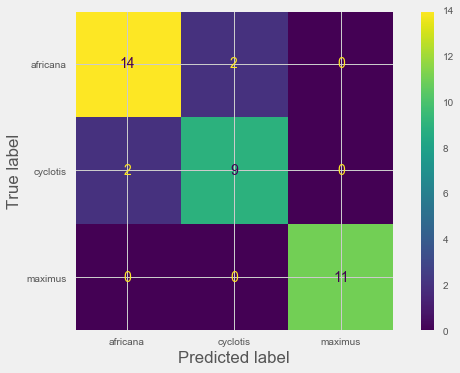

In [94]:
plot_confusion_matrix(gnb, X_test, y_test);